<a href="https://colab.research.google.com/github/mobarakol/Applied_Deep_Learning/blob/main/LeNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Label:  CIFAR10 [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck] <br>

<img src="https://miro.medium.com/max/1010/1*r8S5tF_6naagKOnlIcGXoQ.png" alt="alternatetext">

In [8]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Directory to store CIFAR-10 data
DATA_DIR = './data/cifar10'

# Download CIFAR-10 using torchvision
datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
datasets.CIFAR10(root=DATA_DIR, train=False, download=True)

# File paths for extracted data
train_dir = os.path.join(DATA_DIR, 'cifar-10-batches-py/train')
test_dir = os.path.join(DATA_DIR, 'cifar-10-batches-py/test')

# Define class names for CIFAR-10
CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Custom Dataset class for CIFAR-10
class CIFAR10Dataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load dataset files
        dataset = datasets.CIFAR10(root=DATA_DIR, train=train, download=True)
        self.data = dataset.data
        self.labels = dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read image and label
        image = self.data[idx]
        label = self.labels[idx]

        # Convert image to PIL format
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset instances for training and testing
train_dataset = CIFAR10Dataset(root_dir=train_dir, train=True, transform=transform)
test_dataset = CIFAR10Dataset(root_dir=test_dir, train=False, transform=transform)

# Split training into train/validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define LeNet architecture for CIFAR-10 (input channels = 3)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)  # 3 input channels for RGB images
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)            # Conv layer 2
        self.fc1 = nn.Linear(16 * 6 * 6, 120)                             # Fully connected layer 1
        self.fc2 = nn.Linear(120, 84)                                      # Fully connected layer 2
        self.fc3 = nn.Linear(84, 10)                                        # Fully connected layer 3 (10 classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)                   # Average pooling layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 6 * 6)               # Flatten tensor
        x = self.relu(self.fc1(x))               # FC1 -> ReLU
        x = self.relu(self.fc2(x))               # FC2 -> ReLU
        x = self.fc3(x)                          # FC3
        return x

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Function to train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Function to validate model
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(val_loader), accuracy

# Training loop
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = './best_lenet_cifar10.pth'

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, criterion)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with accuracy: {best_val_accuracy:.2f}%\n")

# Load best model
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20]
Train Loss: 1.9622, Train Accuracy: 27.38%
Validation Loss: 1.6297, Validation Accuracy: 40.24%
Best model saved with accuracy: 40.24%

Epoch [2/20]
Train Loss: 1.5252, Train Accuracy: 44.92%
Validation Loss: 1.4155, Validation Accuracy: 48.98%
Best model saved with accuracy: 48.98%

Epoch [3/20]
Train Loss: 1.3524, Train Accuracy: 51.48%
Validation Loss: 1.3419, Validation Accuracy: 52.01%
Best model saved with accuracy: 52.01%

Epoch [4/20]
Train Loss: 1.2484, Train Accuracy: 55.20%
Validation Loss: 1.2422, Validation Accuracy: 55.71%
Best model saved with accuracy: 55.71%

Epoch [5/20]
Train Loss: 1.1642, Train Accuracy: 58.49%
Validation Loss: 1.2089, Validation Accuracy: 56.81%
Best model saved with accuracy: 56.81%

Epoch [6/20]
Train Loss: 1.0810, Train Accuracy: 61.95%
Validation Loss: 1.1662, Validation Accuracy: 5

#Visualise the Weights

Best model loaded with accuracy: 63.68%


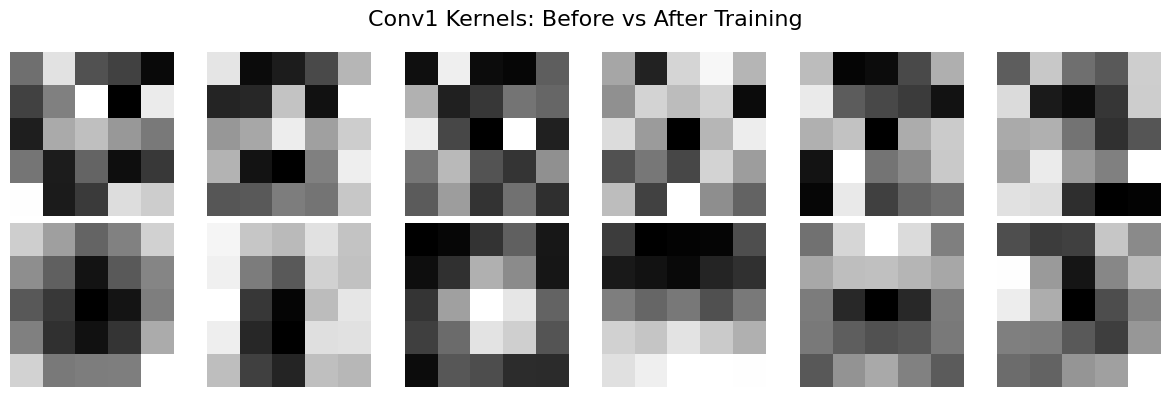

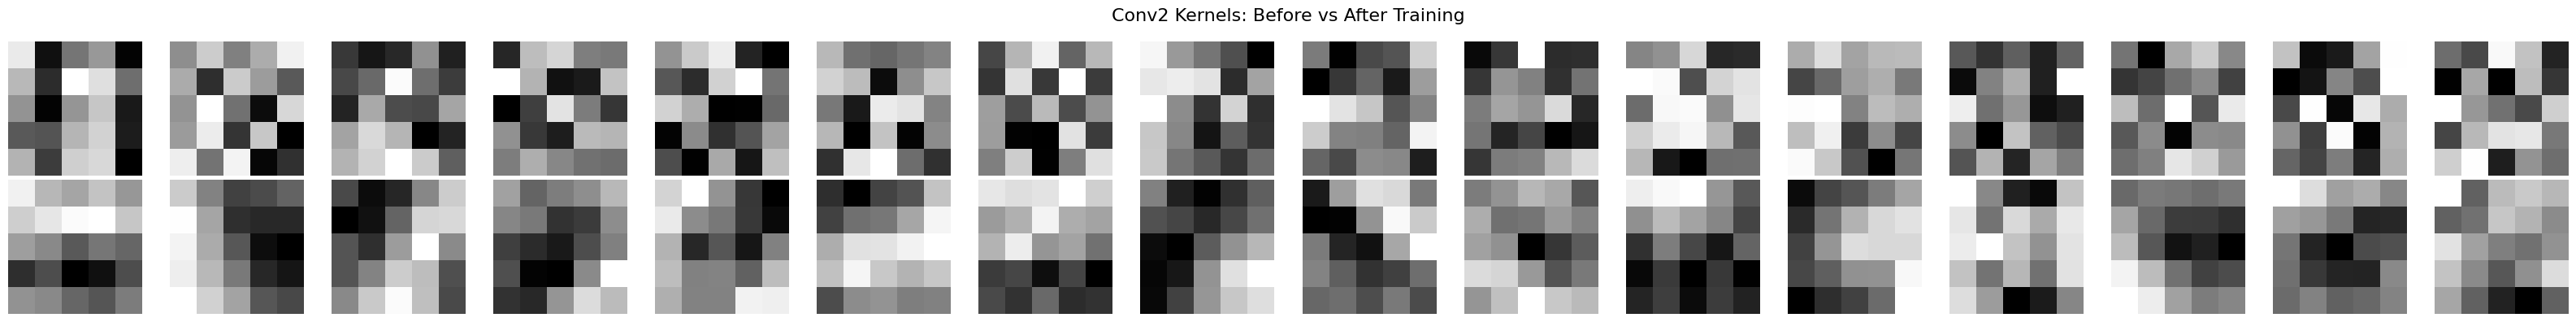

In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import gzip
import torch.nn as nn
import torch.optim as optim

# Function to plot all filters in two rows: before → top, after → bottom
def plot_kernels_before_after(model_before, model_after, layer_name, title):
    layer_before = dict(model_before.named_modules())[layer_name].weight.data.cpu().numpy()
    layer_after = dict(model_after.named_modules())[layer_name].weight.data.cpu().numpy()
    num_kernels = layer_before.shape[0]

    fig, axs = plt.subplots(2, num_kernels, figsize=(num_kernels * 2, 4))  # 2 rows, num_kernels columns

    fig.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        # Plot BEFORE training
        axs[0, i].imshow(layer_before[i, 0], cmap='gray')
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel("Before", fontsize=12)

        # Plot AFTER training
        axs[1, i].imshow(layer_after[i, 0], cmap='gray')
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel("After", fontsize=12)

    plt.tight_layout()
    plt.show()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create two models:
# 1. model_before - for showing initial random weights
# 2. model_after - for showing learned weights after training
model_before = LeNet().to(device)
model_after = LeNet().to(device)

# Load trained model weights into model_after
best_model_path = './best_lenet_cifar10.pth'
model_after.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# ✅ Plot Conv1 filters (before and after training)
plot_kernels_before_after(model_before, model_after, 'conv1', 'Conv1 Kernels: Before vs After Training')

# ✅ Plot Conv2 filters (before and after training)
plot_kernels_before_after(model_before, model_after, 'conv2', 'Conv2 Kernels: Before vs After Training')


#Visualise Feature Maps

Best model loaded with accuracy: 63.68%


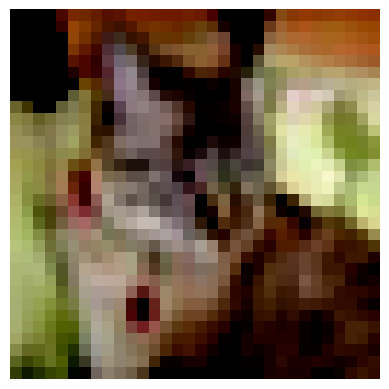

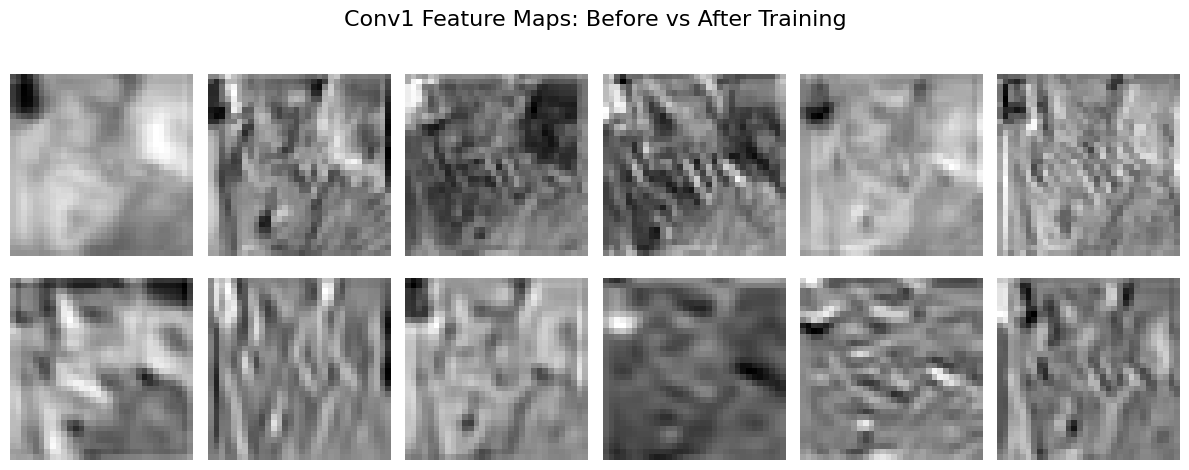

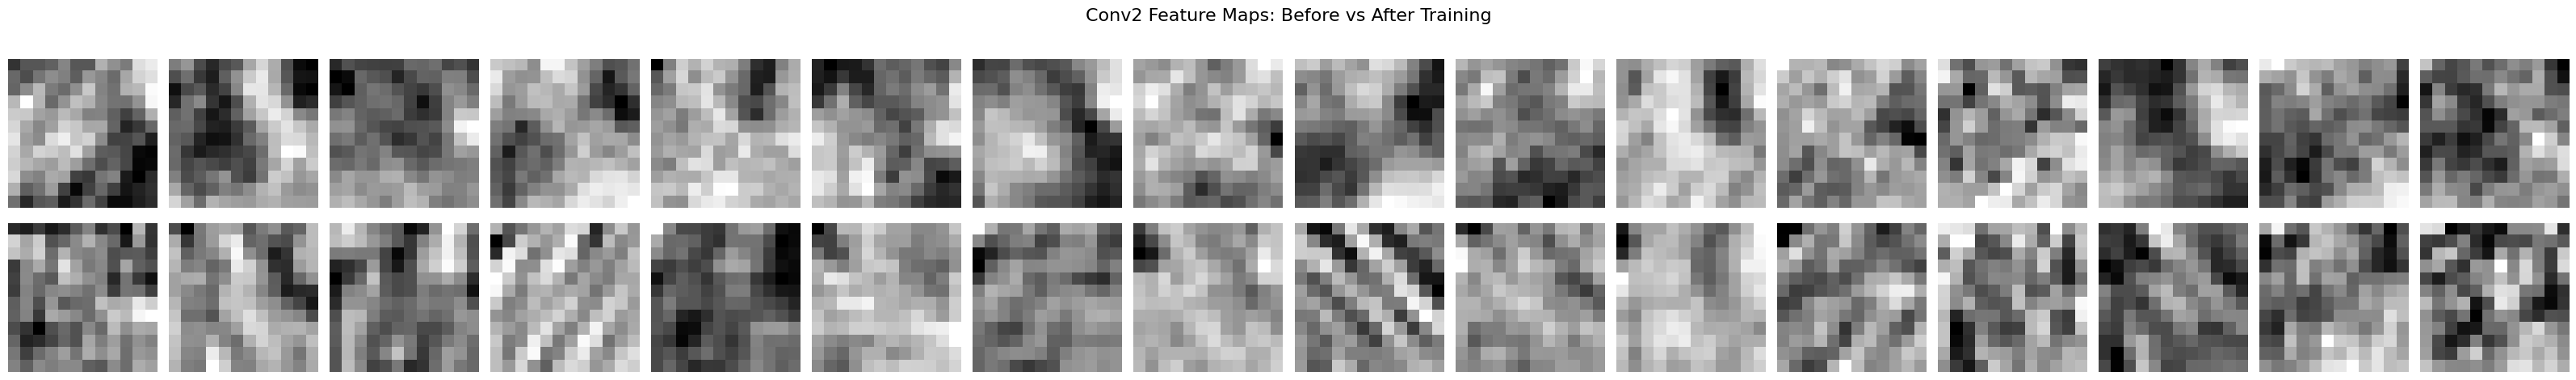

In [25]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import gzip
import torch.nn as nn
import torch.optim as optim

# Function to extract feature maps using forward hooks
def get_feature_maps(model, layer_name, input_sample):
    activation = {}

    def hook_fn(module, input, output):
        activation[layer_name] = output.detach()

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    _ = model(input_sample)  # Forward pass through the model
    handle.remove()

    feature_maps = activation[layer_name].cpu().numpy()
    return feature_maps

# Function to plot feature maps before and after training
def plot_feature_maps(before_maps, after_maps, title):
    num_maps = before_maps.shape[1]

    fig, axs = plt.subplots(2, num_maps, figsize=(num_maps * 2, 5))

    fig.suptitle(title, fontsize=16)

    for i in range(num_maps):
        # Before training
        axs[0, i].imshow(before_maps[0, i], cmap='gray')
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel("Before", fontsize=12)

        # After training
        axs[1, i].imshow(after_maps[0, i], cmap='gray')
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel("After", fontsize=12)

    plt.tight_layout()
    plt.show()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_before = LeNet().to(device)
model_after = LeNet().to(device)

# Load trained model weights into model_after
best_model_path = './best_lenet_cifar10.pth'
model_after.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# Load a sample from test set
sample_image, _ = test_dataset[8]  # Take the first test sample
plt.imshow(sample_image.permute(1,2,0))
plt.axis('OFF')
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# ✅ Extract feature maps before and after training for conv1
before_maps_conv1 = get_feature_maps(model_before, 'conv1', sample_image)
after_maps_conv1 = get_feature_maps(model_after, 'conv1', sample_image)

# ✅ Plot Conv1 feature maps (before and after training)
plot_feature_maps(before_maps_conv1, after_maps_conv1, 'Conv1 Feature Maps: Before vs After Training')

# ✅ Extract feature maps before and after training for conv2
before_maps_conv2 = get_feature_maps(model_before, 'conv2', sample_image)
after_maps_conv2 = get_feature_maps(model_after, 'conv2', sample_image)

# ✅ Plot Conv2 feature maps (before and after training)
plot_feature_maps(before_maps_conv2, after_maps_conv2, 'Conv2 Feature Maps: Before vs After Training')


#Transfer Learnign of CIFAR10 to MNIST Digits Classification
Freeze self.conv1 and self.conv2 and finetune other layers

In [28]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 trained model path
CIFAR10_MODEL_PATH = './best_lenet_cifar10.pth'

# Load MNIST dataset and convert to RGB
class MNISTRGB(Dataset):
    def __init__(self, train=True, transform=None):
        self.data = datasets.MNIST(root='./data/mnist', train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load gray-scale image and convert to RGB by repeating channels
        img, label = self.data[idx]
        img = img.convert("RGB")  # Convert grayscale to RGB
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transform for MNIST to match CIFAR-10 input format
transform = transforms.Compose([
    transforms.Resize((32, 32)),           # Resize MNIST (28x28) to CIFAR-10 (32x32)
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),   # Normalize using CIFAR-10 stats
                         (0.5, 0.5, 0.5))
])

# Create MNIST dataset and DataLoader
train_dataset = MNISTRGB(train=True, transform=transform)
test_dataset = MNISTRGB(train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define LeNet architecture (same as CIFAR-10)
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)  # Input: 3 channels (RGB)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 6 * 6)               # Flatten tensor
        x = self.relu(self.fc1(x))               # FC1 -> ReLU
        x = self.relu(self.fc2(x))               # FC2 -> ReLU
        x = self.fc3(x)                          # FC3
        return x

# Initialize the model and load pretrained weights from CIFAR-10
model = LeNet(num_classes=10).to(device)

# Load CIFAR-10 pretrained weights (excluding the final layer)
state_dict = torch.load(CIFAR10_MODEL_PATH, weights_only=True)
model.load_state_dict(state_dict, strict=False)  # Allow partial loading of weights

# ❄️ Freeze the convolutional layers (conv1 and conv2)
for param in model.conv1.parameters():
    param.requires_grad = False

for param in model.conv2.parameters():
    param.requires_grad = False

# Update the final layer to match MNIST output (10 classes)
model.fc3 = nn.Linear(84, 10).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Function to train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Function to evaluate the model
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(data_loader), accuracy

# Training loop
num_epochs = 10
best_test_accuracy = 0.0
best_model_path = './best_lenet_mnist_from_cifar10.pth'

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Save the model if test accuracy improves
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with accuracy: {best_test_accuracy:.2f}%\n")

# Load best model
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_test_accuracy:.2f}%")

# Final evaluation on test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10]
Train Loss: 0.3417, Train Accuracy: 89.92%
Test Loss: 0.1248, Test Accuracy: 96.20%
Best model saved with accuracy: 96.20%

Epoch [2/10]
Train Loss: 0.1163, Train Accuracy: 96.46%
Test Loss: 0.0932, Test Accuracy: 97.09%
Best model saved with accuracy: 97.09%

Epoch [3/10]
Train Loss: 0.0878, Train Accuracy: 97.35%
Test Loss: 0.0741, Test Accuracy: 97.71%
Best model saved with accuracy: 97.71%

Epoch [4/10]
Train Loss: 0.0733, Train Accuracy: 97.75%
Test Loss: 0.0651, Test Accuracy: 97.94%
Best model saved with accuracy: 97.94%

Epoch [5/10]
Train Loss: 0.0641, Train Accuracy: 98.04%
Test Loss: 0.0611, Test Accuracy: 98.10%
Best model saved with accuracy: 98.10%

Epoch [6/10]
Train Loss: 0.0572, Train Accuracy: 98.27%
Test Loss: 0.0540, Test Accuracy: 98.24%
Best model saved with accuracy: 98.24%

Epoch [7/10]
Train Loss: 0.0522, Train Accuracy: 98.39%
Test Loss: 0.0521, Test Accuracy: 98.32%
Best model saved with accuracy: 98.32%

Epoch [8/10]
Train Loss: 0.0479, Train Ac